In [24]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/home-loan/test.csv
/kaggle/input/home-loan/train.csv


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import gc
import joblib
warnings.filterwarnings("ignore")

In [26]:
from time import perf_counter,time
from contextlib import contextmanager
@contextmanager
def timer(operation_name):
    start = time()
    yield
    end = time()
    print(f'{operation_name} done in {end-start}')

In [27]:
inputs = '../input/home-loan'

In [28]:
train = pd.read_csv(f'{inputs}/train.csv')
test = pd.read_csv(f'{inputs}/test.csv')
target = 'Loan_Status'
train[target] = train[target].map(dict(Y=1,N=0))

In [29]:
print(train.shape)
print('*'*20)
print(test.shape)


(614, 13)
********************
(367, 12)


In [30]:
pre_train = train.copy()
pre_test = test.copy()
for df in [pre_train,pre_test]:
    df.drop(['Loan_ID'],axis=1,inplace=True)

In [31]:
default_columns = pre_test.columns.tolist()
filename= 'default_columns.pkl'
joblib.dump(default_columns,filename)

['default_columns.pkl']

In [32]:
#imputing missing value and treat outliers
#For numerical variables: imputation using mean or median
#For categorical variables: imputation using mode
pre_train['train'] = 1
pre_test['train'] = 0
data = pd.concat([pre_train,pre_test],ignore_index=True,sort=False)

data['Gender'].fillna(data['Gender'].mode()[0],inplace=True)
data['Married'].fillna(data['Married'].mode()[0],inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0],inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0],inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0],inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0],inplace=True)

#we saw that loan amount have outliers so the mean will not be the proper approach as it is highly affected by the presence of outliers.
#so let's use the median
data['LoanAmount'].fillna(data['LoanAmount'].median(),inplace=True)

pre_train=data[data['train']==1].drop(['train'],axis=1)
pre_test=data[data['train']==0].drop(['train','Loan_Status'],axis=1)
del data
gc.collect();

### Feature Engineering

In [33]:

for df in [pre_train,pre_test]:
    #Total income
    df['TotalIncome'] = df['ApplicantIncome']  + df['CoapplicantIncome']
    #the monthly amount to be paid
    df['monthly_amount'] = df['LoanAmount']/df['Loan_Amount_Term']
    #the income left after the monthly amount has been paid
    df['left_income'] = df['TotalIncome'] - df['monthly_amount']*1000
    
    

In [34]:
all_features = ['Gender',
                'Married',
                'Dependents',
                'Education', 
                'Self_Employed',
                'ApplicantIncome',
                'CoapplicantIncome',
                'LoanAmount',
                'Loan_Amount_Term',
                'Credit_History',
                'Property_Area',
                'TotalIncome',
                'monthly_amount',
                'left_income',
               ]

In [35]:
#encoding feature
X = pre_train[all_features]
y = pre_train[target]
X_test = pre_test[all_features]

cat_columns = [col for col in all_features if str(X[col].dtype) =='object']
filename = 'categorical_features.pkl'
joblib.dump(cat_columns,filename)

X = pd.get_dummies(X,columns=cat_columns)
X_test = pd.get_dummies(X_test,columns=cat_columns)

filename = 'model_features.pkl'
model_features = X.columns.tolist()
joblib.dump(model_features,filename)
#del pre_train,pre_test
#gc.collect()

['model_features.pkl']

In [36]:
from imblearn.over_sampling import SMOTE
def resampling(X,y):
    smote = SMOTE(sampling_strategy='minority')
    X,y = smote.fit_resample(X,y)
    return (X,y)
X,y = resampling(X,y)

### Modeling

In [37]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score,confusion_matrix

In [38]:
def plot_cm(y_true, y_pred, title, figsize=(7,6)):
    y_pred = y_pred.round().astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [39]:
nfolds = 5
kfolds=KFold(n_splits=nfolds, shuffle=True, random_state=10)

In [40]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3,random_state=42)

### LGB Algorithm

#### LGB Train & Predict

In [41]:
lgb_params={'learning_rate': 0.001, 
            'max_depth': -1, 
            'num_leaves':2**7+1,
            'metric': 'rmse',
            'random_state': 7, 
            'n_jobs':-1,
            'objective': 'binary',
            'boosting_type': 'gbdt'
            }
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)
feature_importances = pd.DataFrame()
feature_importances['feature'] = model_features

In [42]:
with timer('LGB Training'):
    model_lgb = lgb.train(lgb_params,dtrain,num_boost_round = 10000,valid_sets = [dtrain, dvalid],early_stopping_rounds = 200,verbose_eval=100)

Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.471896	valid_1's rmse: 0.477812
[200]	training's rmse: 0.447292	valid_1's rmse: 0.458286
[300]	training's rmse: 0.426004	valid_1's rmse: 0.441864
[400]	training's rmse: 0.405964	valid_1's rmse: 0.427931
[500]	training's rmse: 0.388414	valid_1's rmse: 0.416608
[600]	training's rmse: 0.373027	valid_1's rmse: 0.407339
[700]	training's rmse: 0.359689	valid_1's rmse: 0.399553
[800]	training's rmse: 0.348176	valid_1's rmse: 0.393587
[900]	training's rmse: 0.338017	valid_1's rmse: 0.388714
[1000]	training's rmse: 0.328595	valid_1's rmse: 0.384204
[1100]	training's rmse: 0.32015	valid_1's rmse: 0.380365
[1200]	training's rmse: 0.312666	valid_1's rmse: 0.37726
[1300]	training's rmse: 0.305321	valid_1's rmse: 0.375259
[1400]	training's rmse: 0.298241	valid_1's rmse: 0.373968
[1500]	training's rmse: 0.291887	valid_1's rmse: 0.373156
[1600]	training's rmse: 0.286036	valid_1's rmse: 0.372589
[1700]	training's rms

In [43]:
with timer('OOF -LGB prediction'):
    y_pred_lgb = model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)

OOF -LGB prediction done in 0.024401187896728516


In [44]:
#define a threshold
y_lgb = (y_pred_lgb >0.52) 
accuracy_score(y_valid, y_lgb)

0.8149606299212598

#### LGB- Evaluation

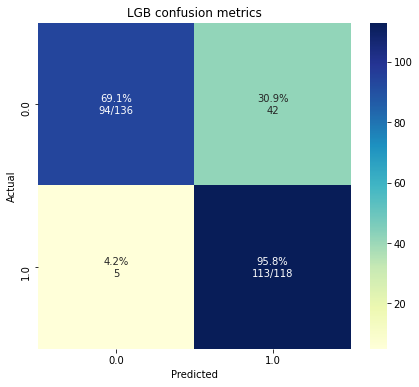

In [45]:
plot_cm(y_valid,y_lgb,'LGB confusion metrics')

### XGB Algorithm

In [46]:
xgb_params={'colsample_bytree': 0.8,
            'learning_rate': 0.001,
            'max_depth': 10,
            'subsample': 1,
            'objective':'binary:logistic',
            'eval_metric':'rmse',
            'min_child_weight':1,
            'gamma':0.25,
            'n_estimators':5000,
            'verbosity':0       
           }

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)

In [47]:
with timer('XGB Training'):
    model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=5000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=200)

[0]	train-rmse:0.49968	val-rmse:0.49977
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[200]	train-rmse:0.44578	val-rmse:0.46195
[400]	train-rmse:0.40059	val-rmse:0.43256
[600]	train-rmse:0.36355	val-rmse:0.41153
[800]	train-rmse:0.33247	val-rmse:0.39513
[1000]	train-rmse:0.30615	val-rmse:0.38255
[1200]	train-rmse:0.28364	val-rmse:0.37360
[1400]	train-rmse:0.26473	val-rmse:0.36741
[1600]	train-rmse:0.24841	val-rmse:0.36323
[1800]	train-rmse:0.23430	val-rmse:0.36062
[2000]	train-rmse:0.22205	val-rmse:0.35881
[2200]	train-rmse:0.21081	val-rmse:0.35756
[2400]	train-rmse:0.20082	val-rmse:0.35692
[2600]	train-rmse:0.19187	val-rmse:0.35659
Stopping. Best iteration:
[2566]	train-rmse:0.19331	val-rmse:0.35654

XGB Training done in 3.0463509559631348


In [48]:
with timer('OOF -XGB prediction'):
    y_pred_xgb = model_xgb.predict(xgb.DMatrix(X_valid))

OOF -XGB prediction done in 0.03495907783508301


In [49]:
#define a threshold
y_xgb = (y_pred_xgb >0.52) 
accuracy_score(y_valid, y_xgb)

0.8307086614173228

In [50]:
y_pred_xgb

array([0.70665973, 0.92142844, 0.04760101, 0.07745799, 0.07338823,
       0.66409147, 0.05177571, 0.12832353, 0.6265917 , 0.77488166,
       0.70554435, 0.17153528, 0.44910675, 0.0842909 , 0.8697427 ,
       0.8915282 , 0.04723937, 0.61505604, 0.8820272 , 0.8078415 ,
       0.10695934, 0.8273292 , 0.84686   , 0.09381247, 0.7542157 ,
       0.7331243 , 0.22033215, 0.8304079 , 0.7200927 , 0.79877836,
       0.88475555, 0.70701355, 0.8096335 , 0.68724746, 0.04944849,
       0.59689265, 0.8754496 , 0.89129627, 0.06342481, 0.06803508,
       0.86203295, 0.9451889 , 0.91408604, 0.09230924, 0.09653378,
       0.6525027 , 0.05511583, 0.8626715 , 0.11855569, 0.05182567,
       0.76663506, 0.8313271 , 0.90147007, 0.7378789 , 0.04743131,
       0.04749219, 0.8790242 , 0.71381325, 0.10546403, 0.05495577,
       0.21331654, 0.05170703, 0.8273747 , 0.75776196, 0.6945756 ,
       0.84802884, 0.12615532, 0.05026938, 0.05402006, 0.04421214,
       0.1257953 , 0.9241617 , 0.86817527, 0.81983167, 0.13445

#### XGB- Evaluation

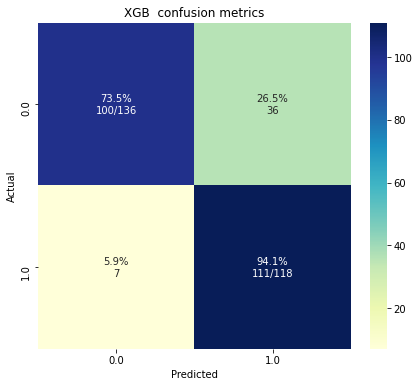

In [51]:
plot_cm(y_valid,y_xgb,'XGB  confusion metrics')

### LGB Algorithm -Kfold

In [52]:
with timer('LGB-KFOLD Training'):
    oof_valid_lgb = np.zeros((len(X)))
    y_test_lgb = np.zeros((len(X_test)))
    y_train_lgb = np.zeros(len(X))

    for fold,(train_idx,val_idx) in (enumerate (kfolds.split(X,y))):
        X_train,X_valid = X.loc[train_idx],X.loc[val_idx]
        y_train,y_valid = y.loc[train_idx],y.loc[val_idx]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)

        model_lgb_kfold= lgb.train(lgb_params,dtrain,num_boost_round = 5000,valid_sets = [dtrain, dvalid],early_stopping_rounds = 100,verbose_eval=200)
        #feature_importances['fold_{}'.format(fold+1)] = model_lgb_kfold.feature_importance()

        oof_valid_lgb[val_idx] = model_lgb_kfold.predict(X_valid,num_iteration=model_lgb_kfold.best_iteration)
        y_test_lgb += model_lgb_kfold.predict(X_test)/nfolds
        y_train_lgb += model_lgb_kfold.predict(X)/nfolds

        del X_train, X_valid, y_train, y_valid
        gc.collect()

Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.448138	valid_1's rmse: 0.462283
[400]	training's rmse: 0.407306	valid_1's rmse: 0.433812
[600]	training's rmse: 0.375782	valid_1's rmse: 0.414101
[800]	training's rmse: 0.351193	valid_1's rmse: 0.400269
[1000]	training's rmse: 0.331412	valid_1's rmse: 0.391739
[1200]	training's rmse: 0.314525	valid_1's rmse: 0.384877
[1400]	training's rmse: 0.30032	valid_1's rmse: 0.379654
[1600]	training's rmse: 0.288254	valid_1's rmse: 0.376467
[1800]	training's rmse: 0.278264	valid_1's rmse: 0.37515
[2000]	training's rmse: 0.269687	valid_1's rmse: 0.374083
[2200]	training's rmse: 0.262284	valid_1's rmse: 0.373851
Early stopping, best iteration is:
[2144]	training's rmse: 0.264256	valid_1's rmse: 0.373743
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.452945	valid_1's rmse: 0.454064
[400]	training's rmse: 0.414085	valid_1's rmse: 0.416473
[600]	training's rmse: 0.383814	valid

In [53]:
y_lgb_kfold = (oof_valid_lgb>0.52)*1
accuracy_score(y,y_lgb_kfold)

0.8625592417061612

#### LGB- Evaluation

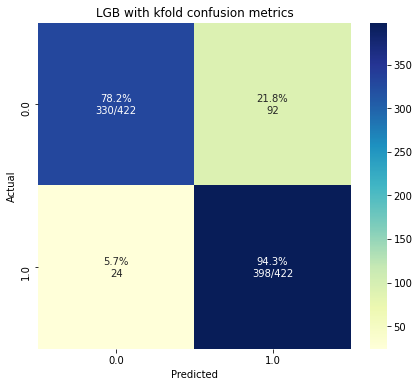

In [54]:
plot_cm(y,y_lgb_kfold,'LGB with kfold confusion metrics')

In [55]:
#pickle LGB-5fold
filename='lgb_5_fold.pkl'
joblib.dump(model_lgb_kfold,filename)

['lgb_5_fold.pkl']

### XGB Algorithm -Kfold

In [56]:
with timer('XGB-KFOLD Training'):
    oof_valid_xgb = np.zeros(len(X))
    y_test_xgb = np.zeros(len(X_test))
    y_train_xgb = np.zeros(len(X))


    for fold,(train_idx,val_idx) in (enumerate (kfolds.split(X,y))):
        X_train,X_valid = X.loc[train_idx],X.loc[val_idx]
        y_train,y_valid = y.loc[train_idx],y.loc[val_idx]
        dtrain = xgb.DMatrix(X_train, y_train)
        dvalid = xgb.DMatrix(X_valid, y_valid)

        model_xgb_kfold = xgb.train(xgb_params, dtrain, num_boost_round=5000, evals=[(dtrain, 'train'), (dvalid, 'val')], early_stopping_rounds=100, verbose_eval=200)

        oof_valid_xgb[val_idx] = model_xgb_kfold.predict(xgb.DMatrix(X_valid))
        y_test_xgb += model_xgb_kfold.predict(xgb.DMatrix(X_test))/nfolds
        y_train_xgb += model_xgb_kfold.predict(xgb.DMatrix(X))/nfolds

        del X_train, X_valid, y_train, y_valid
        gc.collect()

[0]	train-rmse:0.49969	val-rmse:0.49978
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[200]	train-rmse:0.44578	val-rmse:0.46396
[400]	train-rmse:0.40052	val-rmse:0.43581
[600]	train-rmse:0.36251	val-rmse:0.41630
[800]	train-rmse:0.33025	val-rmse:0.40161
[1000]	train-rmse:0.30329	val-rmse:0.39141
[1200]	train-rmse:0.28109	val-rmse:0.38473
[1400]	train-rmse:0.26198	val-rmse:0.38059
[1600]	train-rmse:0.24579	val-rmse:0.37761
[1800]	train-rmse:0.23190	val-rmse:0.37577
[2000]	train-rmse:0.21976	val-rmse:0.37436
[2200]	train-rmse:0.20925	val-rmse:0.37297
[2400]	train-rmse:0.19973	val-rmse:0.37239
[2600]	train-rmse:0.19109	val-rmse:0.37204
Stopping. Best iteration:
[2634]	train-rmse:0.18969	val-rmse:0.37200

[0]	train-rmse:0.49971	val-rmse:0.49976
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[200]	train

In [57]:
y_xgb_kfold = (oof_valid_xgb>0.52)*1
accuracy_score(y,y_xgb_kfold)

0.8388625592417062

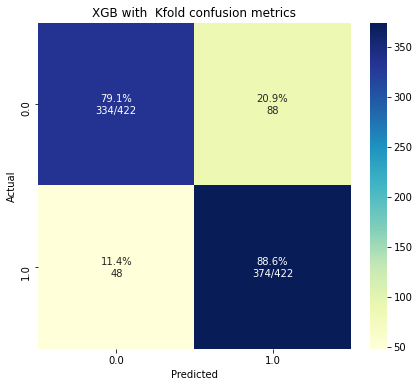

In [58]:
plot_cm(y,y_xgb_kfold,'XGB with  Kfold confusion metrics')

In [59]:
#pickle XGB-5fold
filename='XGB_5_fold.pkl'
joblib.dump(model_xgb_kfold,filename)

['XGB_5_fold.pkl']

### Ensembling

In [60]:
from tqdm import tqdm
accs = []
alphas = np.linspace(0,1,101)

# loop for every alpha
for alpha in tqdm(alphas):
    y_pred = alpha*y_xgb_kfold + (1 - alpha)*y_lgb_kfold
    acc = accuracy_score(y,(y_pred>0.52)*1)
    accs.append(acc)

# convert to numpy array
accs = np.array(accs)

# get best_alpha
best_alpha = alphas[np.argmax(accs)]

print('best_accuracy=', accs.max())
print('best_alpha=', best_alpha)

100%|██████████| 101/101 [00:00<00:00, 1725.03it/s]

best_accuracy= 0.8625592417061612
best_alpha= 0.0


In [61]:
y_ensemble =  0.5*y_xgb_kfold + 0.5* y_lgb_kfold
y_ensemble=(y_ensemble>0.52)*1
accuracy_score(y,y_ensemble)

0.8388625592417062

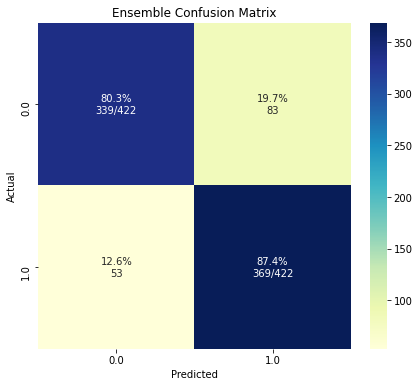

In [62]:
plot_cm(y,y_ensemble,'Ensemble Confusion Matrix')